# Quora Insinscere question detection
This is a notebook to explore the challenge of deecting if a given question on quora is sinscere or not. More details can be found at - 
https://www.kaggle.com/c/quora-insincere-questions-classification/data

Why - 
I found this problem really intterestin because insinscerity is a very subtle trait to detect. It is hard to come up with simple rules involving presence/absence of phrases or patters that can detect insinscerity.
It would be interesting to see what LSTMs can achieve given the complex nature of the problem.

Challenges -
THe good thing is there is plenty of data - around 1.3 mn examples for training models. The tricky part is that I do not have the hardware capability to train on such a huge dataset so I will be using a small subset. However my intent is not to achieve state of the art performance but to understand and explore LSTMs.

## The approach
Rough outline of the approaches I plan to exxpreiment with - 

- Use linear models on sentence embeddings, exploring various approaches to get sentence embeddings from word embeddings
- Use NN on sentence embeddings
- Use LSTM on word embeddings

Word embeddings are very helpful and will help transform our examples into a desne and meaningful form.
Linear models on top of these will give the baseline perofmrnace that we hope will be surpassed by deep leaning methods.
Simple deep fully connected netwrk on top of word embeddings will capture the non-linear relationships that the linear model would have missed
Finally an LSTM will capture sequential patterns in the example text which neither of the previous methods do. In a problem as subtle as this - I hypothesise that an LSTM(if trained right) should outperform both the above methods.

In [3]:
# Setup - loading libraries and data
import pandas as pd
import numpy as np
import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
%matplotlib inline

train = pd.read_csv("data/train.csv" , index_col = "qid")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1306122 entries, 00002165364db923c7e6 to ffffed09fedb5088744a
Data columns (total 2 columns):
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(1)
memory usage: 29.9+ MB


In [4]:
train.head()

,question_text,target
qid,,
00002165364db923c7e6,How did Quebec nationalists see their province...,0
000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
(train['target'].value_counts() / train.shape[0])

0    0.93813
1    0.06187
Name: target, dtype: float64

## The data
Each observation in our data is a questions asked on quora and a target variable which is an integer indicating if the questiong was insinscere or not. We have aeounf 1.3 mn examples. No missing values in either field. 
Data set is imbalanced. Only around 6.1% of the total questions we have are insinscere questions. Such imbalance has repurcussions on how we train and evaluate our model. For ex. a 'dumb' model that always predicts that the question is not insinscere will be right ~94% of the times on our training data. Any model we train should be able to do better than at least that.

In [5]:
# Train test split
train_df, test_df = train_test_split(train , train_size = 0.7, random_state = 1)


/Users/dhruv/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Using sentence embeddings

Here I use Glove 50 dimnesional embeddings that are available for download for free. Higher dimnesional embeddings are definitely more helpful but increase computation requirements. 
Glove embeddings map each word to a 50 d numerical vector. To map a sentence(a question in our case) to a 50 d vector - I simply take the average od embeddings for each word in the sentence.


In [6]:
# Loading word embeddings
words_to_index, index_to_words, word_to_vec_map = utils.read_glove_vecs('data/glove.6B.50D.txt')
embed_size = word_to_vec_map['potatoes'].shape[0]

In [7]:
# Getting sentence embeddings
embed_feature_matrix = np.zeros((train.shape[0] , embed_size))

for i in range(train.shape[0]):
    avg = np.zeros(embed_size)
    sentence = train['question_text'].iloc[i]
    for w in sentence.split():
        avg = (avg + word_to_vec_map[w.lower()]) if w in words_to_index.keys() else avg
    avg = avg/len(sentence.split())
    embed_feature_matrix[i,:] = avg

In [8]:
# Example of embedding for one question
embed_feature_matrix[1,:]

array([ 0.30652914, -0.04615969,  0.03461759, -0.32862106,  0.32389972,
        0.11798259, -0.31097   , -0.17440473, -0.18743   ,  0.05849787,
        0.02323312,  0.25310656, -0.04408219, -0.06636275,  0.39459031,
        0.41205156,  0.19186312, -0.04145169,  0.17174231, -0.51833125,
       -0.02230881,  0.20463238,  0.230813  ,  0.08086213,  0.27062426,
       -1.4915    , -0.31363788, -0.16113384,  0.28794744, -0.42191206,
        2.8637    ,  0.37205625, -0.5678375 , -0.36670375,  0.00532304,
       -0.16805575,  0.08249931, -0.00493012, -0.05710663, -0.15098275,
       -0.27497237,  0.01004969,  0.20942125,  0.27642663,  0.13349706,
        0.03729038, -0.22709063,  0.06868144, -0.03569675,  0.20406713])

In [10]:
#fitting a linear logistic model to predict insinscere questions
logistic_model = LogisticRegression(penalty= "l2" , C = 1)
logistic_model.fit(embed_feature_matrix , train['target'])

/Users/dhruv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
test_pred_proba_losgistic_model = logistic_model.predict_proba(embed_feature_matrix)
test_pred_losgistic_model = logistic_model.predict(embed_feature_matrix)

accuracy  = accuracy_score(train['target'] , test_pred_losgistic_model )
f1 = f1_score(train['target'] , test_pred_losgistic_model)

from sklearn.metrics import roc_auc_score 
rocauc = roc_auc_score(train['target'] ,test_pred_proba_losgistic_model[:,1])
print("ROC AUC Score -" ,rocauc)
print("Accuracy Score -" ,accuracy)
print("F1 Score -" ,f1)



ROC AUC Score - 0.8425774343251118
Accuracy Score - 0.9371528846463041
F1 Score - 0.11915441570984013


array([0.23020887, 0.17548449, 0.00072345, ..., 0.00223327, 0.00172832,
       0.04838918])

Decent performance for logistic regression with sentence embeddings. This was to be expected since insinscerity is a very subtle trait that is hard to pick up on without word sequence information - which is lost while averaging word embeddings to get sentence embeddings. We need to have a model that captures the context better.

## RNN with word embeddings

In [18]:

from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform


Using TensorFlow backend.


In [19]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    """
    
    vocab_len = len(word_to_index) + 1                  
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    emb_matrix = np.zeros((vocab_len , emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    embedding_layer.build((None,))

    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [20]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.

    """
    
    m = X.shape[0]                                   # number of training examples

    X_indices = np.zeros((m ,max_len ))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = (X[i].lower()).split()
        sentence_words = sentence_words[:min(max_len, len(sentence_words))]

        j = 0

        for w in sentence_words:
            if w in word_to_index.keys():
                X_indices[i, j] = word_to_index[w]
                j = j+1
    
    return X_indices

In [21]:
def LSTM_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating  model's graph.

    """

    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    X = LSTM(256,return_sequences=False )(embeddings)
    X = Dropout(0.2)(X)
    out = Dense(16, activation="relu")(X)
    out = Dense(1, activation="sigmoid")(out)

    model = Model(inputs = sentence_indices , outputs = out)

    
    return model

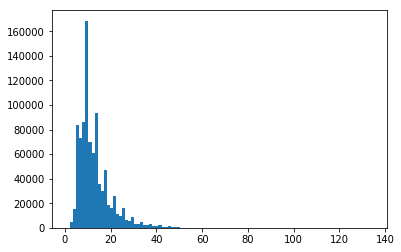

In [23]:
sentence_lens = [len(x.split()) for x in  list(train_df['question_text'])]

import matplotlib.pyplot as plt

plt.hist(sentence_lens , bins = 100)

x = pd.DataFrame(sentence_lens).describe(percentiles = [0,0.1 , 0.9,0.99])



In [24]:
maxLen = int(x.loc['99%'][0])

Going to cap sentence length to 40.

In [25]:

model = LSTM_model((maxLen,), word_to_vec_map, words_to_index)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 39)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 39, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_2 (Dense)      

In [26]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return y_pred


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])

In [27]:
X_train_indices = sentences_to_indices(np.asarray(train_df['question_text']), words_to_index, maxLen)
Y_train = np.asarray(train_df['target'])


In [28]:
X_train_indices.shape

(914285, 39)

In [60]:
history = model.fit(x= X_train_indices[:100000, ], y= Y_train[:100000], batch_size=32, epochs=1, verbose=1, callbacks=None, validation_split=0.2)



Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 169s 2ms/step - loss: 0.2317 - acc: 0.9387 - f1_m: 0.0616 - val_loss: 0.2263 - val_acc: 0.9398 - val_f1_m: 0.0586


In [67]:

y_pred = model.predict(X_train_indices[:100000, ])


dict_keys(['val_loss', 'val_acc', 'val_f1_m', 'loss', 'acc', 'f1_m'])


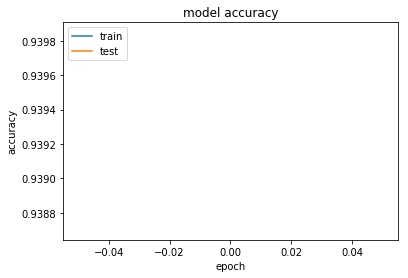

In [68]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


(array([9.4407e+04, 1.9390e+03, 3.0940e+03, 4.1400e+02, 9.8000e+01,
        3.1000e+01, 1.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

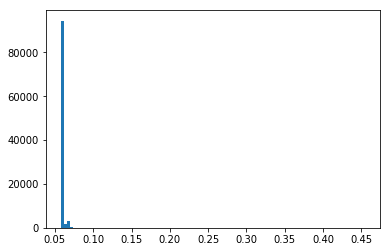

In [69]:

plt.hist(y_pred , bins = 100)

In [70]:
pd.DataFrame(y_pred).describe()

rocauc = roc_auc_score(Y_train[:100000] ,y_pred )
print("ROC AUC Score -" ,rocauc)

ROC AUC Score - 0.6888920713148698


Observations - 
1. ROC AUC better for NN model than linear model
2. Optimum threshold for probability output to get final predictions still need to be caliberated
3. Hyper parameters - batch size, n_epochs to be caliberated based on loss plots - need a more powerful machine
4. Having excessive padding due to just one long sentece was making the network hard to trin - all predictions were the same.
5. Class imbalance means that the probabilities for positive class will always be low and appropriate thresholds have to be chosen. Like in this case - the max output prob is around ~ 7%
